### Time Series Forecast - Selective Reporting

Shows how selective reporting can make model seem to be better.

In [1]:
import os, sys, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
!python --version

Python 3.9.12


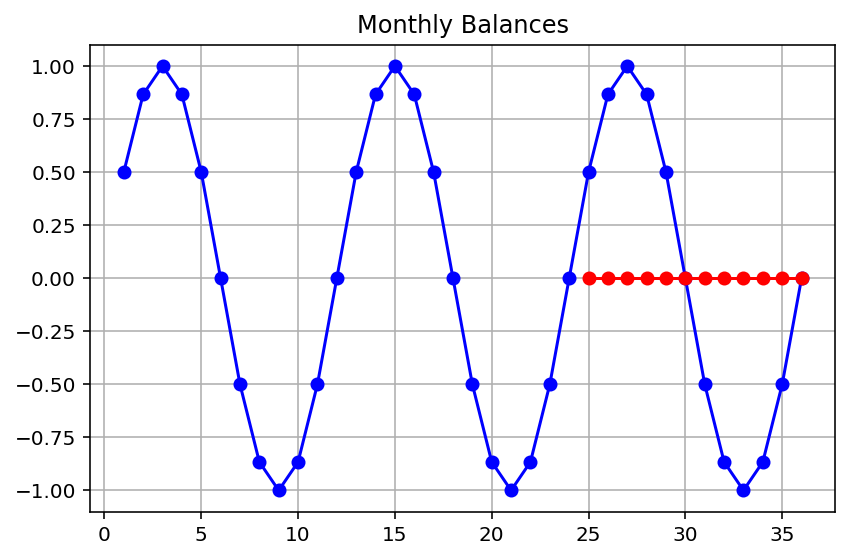

In [3]:
# suppose we have actual values for 3 years (36 months)
months = np.arange(1, 37, 1)
vals   = np.sin(months*2*math.pi/12.0)

# Suppose that we use first 24 months 
# to train a simple forecasting model.
# It is so trivial - it predicts zero values.

months_pred = np.arange(25, 37, 1)
vals_pred   = np.full(12,0)         # 12 points with 0 values 

fig, ax = plt.subplots(figsize=(6,4))
_ = ax.plot(months, vals, color="blue", marker='o')
_ = ax.plot(months_pred, vals_pred, color="red", marker='o')
_ = ax.set_title(f"Monthly Balances")
_ = ax.grid(True)

fig.tight_layout()
plt.show() ; # semicolon needed to remove text output on top

In [4]:
print(vals[24:].shape)
print(vals_pred.shape)

(12,)
(12,)


In [5]:
# Error function wape() needed to select best fit

# ----------------------------------------------------
def wape (actual, predicted, y_norm = None):
    """
    # calculate custom WAPE
    # (Weighted Absolute Percentage Error)
    # between two arrays (or lists)
    # y_norm (when provided) used as denominator
    """
    Na = len(actual)
    Np = len(predicted)
    # -----------------------------
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    # -----------------------------
    # make sure we use numpy arrays
    np_act = np.array(actual)
    np_pre = np.array(predicted)
    # -----------------------------
    nomin = np.abs(np_act - np_pre).sum()
    # -----------------------------
    if y_norm and y_norm > 0:
        return min (1e4, nomin / (y_norm * Na))
    # -----------------------------
    v_max_act   = np.max(np_act)
    v_min_act   = np.min(np_act)
    v_amp_act   = v_max_act - v_min_act    # amplitude
    v_scale_act = np.abs(np_act).sum() / Na
    # -----------------------------
    if (v_scale_act == 0.0) and (nomin != 0.0):
        return 1e4  # this is arbitrary big number    
    # -----------------------------
    if (v_amp_act <= 1e-4 * v_scale_act):
        shifted = (np_act - v_min_act) + v_scale_act
        denom = shifted.sum()
        if (denom == 0.0):
            return 1e4  # this is arbitrary big number 
        else:
            return min (1e4, (nomin / denom))
    # -----------------------------
    # v_amp is reasonably large, shift in units of v_amp
    shifted = (np_act - v_min_act) + 5*v_amp_act
    denom = np.abs(shifted).sum()
    return min (1e4, (nomin / denom))

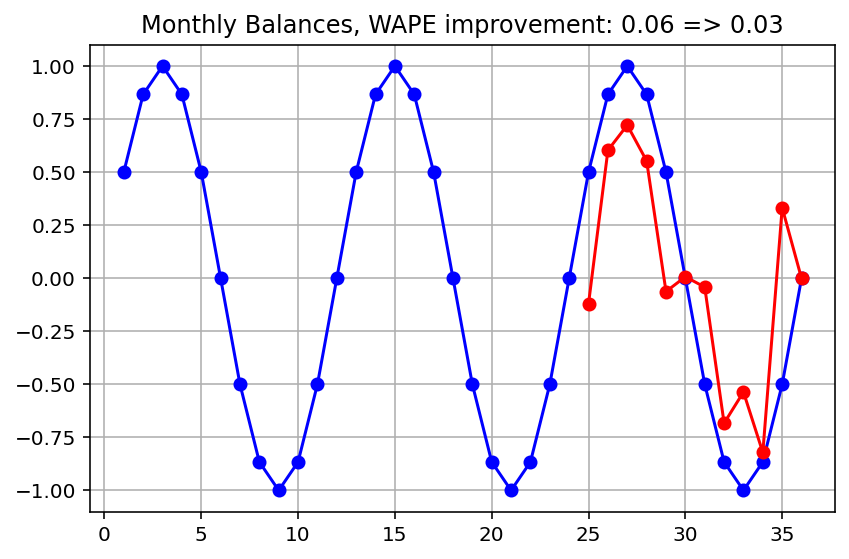

In [6]:
# Now let's see how we can "predict" using selective reporting
# We start with bad prediction
wape_best = wape(vals[24:], vals_pred)
wape_best_orig = wape_best
vals_best = np.full(12,0) 

# generate multiple absolutely random waves
# and select the best fit
N = 1000
for counter in range(N):
    vals_temp = 1.8*(np.random.rand(12) - 0.5)
    wape_temp = wape(vals[24:], vals_temp)
    if wape_temp < wape_best:
        wape_best = wape_temp
        vals_best = vals_temp

# print(f"WAPE improvement: {wape_best_orig} => {wape_best}")
fig, ax = plt.subplots(figsize=(6,4))
_ = ax.plot(months, vals, color="blue", marker='o')
_ = ax.plot(months_pred, vals_best, color="red", marker='o')
_ = ax.set_title(f"Monthly Balances, "+f"WAPE improvement: {wape_best_orig:.2f} => {wape_best:.2f}")
_ = ax.grid(True)

fig.tight_layout()
plt.show() ; # semicolon needed to remove text output on top

So, selective reporting can mimic forecasting.